In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

## Data

In [2]:
df = pd.read_csv("timeseries100.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.014493,-0.043478,-0.053435,-0.095057,-0.114390,-0.018587,0.003984,-0.152540,-0.133550,-0.065041,...,-0.086486,-0.049869,-0.043257,-0.093750,-0.083770,-0.083770,-0.078125,-0.073791,-0.060000,-0.054187
1,-0.068702,-0.028807,-0.008130,-0.016393,0.029536,0.003984,0.031746,-0.015267,-0.007812,-0.011858,...,0.029630,-0.028369,-0.013699,0.009346,0.026549,0.056000,0.017544,-0.053659,-0.027431,0.011321
2,-0.068702,-0.028807,-0.008130,-0.016393,0.029536,0.003984,0.031746,-0.015267,-0.007812,-0.011858,...,0.029630,-0.028369,-0.013699,0.009346,0.026549,0.056000,0.017544,-0.053659,-0.027431,0.011321
3,-0.428570,-0.369230,-0.415490,-0.368820,-0.346460,-0.373580,-0.346460,-0.460000,-0.425610,-0.431510,...,-0.218880,-0.196510,-0.231400,-0.230090,-0.192660,-0.227470,-0.330830,-0.312980,-0.250000,-0.215190
4,-0.015748,0.004049,0.015748,0.033708,0.043478,-0.011583,-0.042017,-0.012766,-0.021097,-0.008547,...,0.083333,0.080537,0.096774,0.087838,0.091549,0.105260,0.076412,0.077922,0.068404,0.064103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.133080,0.082278,0.034700,0.211010,0.080702,0.081678,0.022422,0.041176,0.017370,0.106560,...,0.030303,0.312140,0.000000,0.000000,0.078224,0.000000,0.089744,0.113540,0.139320,0.051546
214,0.043796,0.027237,0.063197,0.085502,0.079848,0.066148,0.053030,0.045802,0.064639,0.074205,...,-0.114190,-0.100370,-0.115940,-0.107270,-0.104170,-0.101050,-0.089552,-0.062731,-0.007692,0.053435
215,0.077307,0.047146,0.073569,0.074468,0.027295,0.080000,0.231830,0.015801,0.035800,0.011601,...,0.065693,0.328300,0.092348,0.015590,0.042453,0.015521,0.030733,0.047859,0.111750,0.104380
216,0.043732,0.034091,0.017143,0.026239,0.029316,0.021978,0.083871,0.010989,0.017045,0.014409,...,-0.028037,0.024561,0.017668,0.010601,0.011407,0.033333,0.043103,-0.009009,-0.008772,-0.034146


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if len(data.shape) == 1 else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
timeseries = df['0'].values

In [6]:
window = 24
data =  series_to_supervised(timeseries, window)

In [7]:
data

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,-0.014493,-0.068702,-0.068702,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,...,0.162920,0.009524,0.287880,0.042654,-0.209880,-0.486880,0.009804,-0.137250,0.317920,0.075000
25,-0.068702,-0.068702,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,...,0.009524,0.287880,0.042654,-0.209880,-0.486880,0.009804,-0.137250,0.317920,0.075000,0.114750
26,-0.068702,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,...,0.287880,0.042654,-0.209880,-0.486880,0.009804,-0.137250,0.317920,0.075000,0.114750,-0.207270
27,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,0.067227,...,0.042654,-0.209880,-0.486880,0.009804,-0.137250,0.317920,0.075000,0.114750,-0.207270,-0.061033
28,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,0.067227,0.104820,...,-0.209880,-0.486880,0.009804,-0.137250,0.317920,0.075000,0.114750,-0.207270,-0.061033,0.079646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.112430,-0.419140,-0.067568,0.208560,0.114090,0.125000,0.153560,-0.153490,0.150840,0.135140,...,0.017857,0.073892,0.071225,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080
214,-0.419140,-0.067568,0.208560,0.114090,0.125000,0.153560,-0.153490,0.150840,0.135140,0.424580,...,0.073892,0.071225,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080,0.043796
215,-0.067568,0.208560,0.114090,0.125000,0.153560,-0.153490,0.150840,0.135140,0.424580,-0.304350,...,0.071225,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080,0.043796,0.077307
216,0.208560,0.114090,0.125000,0.153560,-0.153490,0.150840,0.135140,0.424580,-0.304350,0.152000,...,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080,0.043796,0.077307,0.043732


In [8]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()
train, test = train_test_split(data, test_size=0.1, shuffle=False)
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [9]:
train.shape, test.shape

((174, 25), (20, 25))

In [10]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(174, 24) (174,)
(20, 24) (20,)


In [12]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y_test).type(torch.Tensor).view(-1)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([174, 24]) torch.Size([174])
torch.Size([20, 24]) torch.Size([20])


In [14]:
X_train = X_train.view([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.view([X_test.shape[0], X_test.shape[1], 1])

In [15]:
X_train.shape, X_test.shape

(torch.Size([174, 24, 1]), torch.Size([20, 24, 1]))

In [16]:
class HybridLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(HybridLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out


model = HybridLSTM(input_dim=1, hidden_dim=64, output_dim=1, num_layers=2)  

Epoch: 0, Loss: 1.0020674467086792
Epoch: 10, Loss: 0.9992037415504456
Epoch: 20, Loss: 0.9944989681243896
Epoch: 30, Loss: 0.9794813990592957
Epoch: 40, Loss: 0.957872748374939
Epoch: 50, Loss: 0.9313942193984985
Epoch: 60, Loss: 0.9001686573028564
Epoch: 70, Loss: 0.8565381169319153
Epoch: 80, Loss: 0.8285596370697021
Epoch: 90, Loss: 0.7901724576950073
Epoch: 100, Loss: 0.7602508664131165
Epoch: 110, Loss: 0.7607394456863403
Epoch: 120, Loss: 0.7214402556419373
Epoch: 130, Loss: 0.691561222076416
Epoch: 140, Loss: 0.6670783758163452
Epoch: 150, Loss: 0.6545887589454651
Epoch: 160, Loss: 0.628330647945404
Epoch: 170, Loss: 0.6018285751342773
Epoch: 180, Loss: 0.5693511366844177
Epoch: 190, Loss: 0.5337492227554321
Epoch: 200, Loss: 0.5229586958885193
Epoch: 210, Loss: 0.4751143157482147
Epoch: 220, Loss: 0.44036224484443665
Epoch: 230, Loss: 0.41142737865448
Epoch: 240, Loss: 0.3637254536151886
Epoch: 250, Loss: 0.33286455273628235
Epoch: 260, Loss: 0.36799249053001404
Epoch: 270, Lo

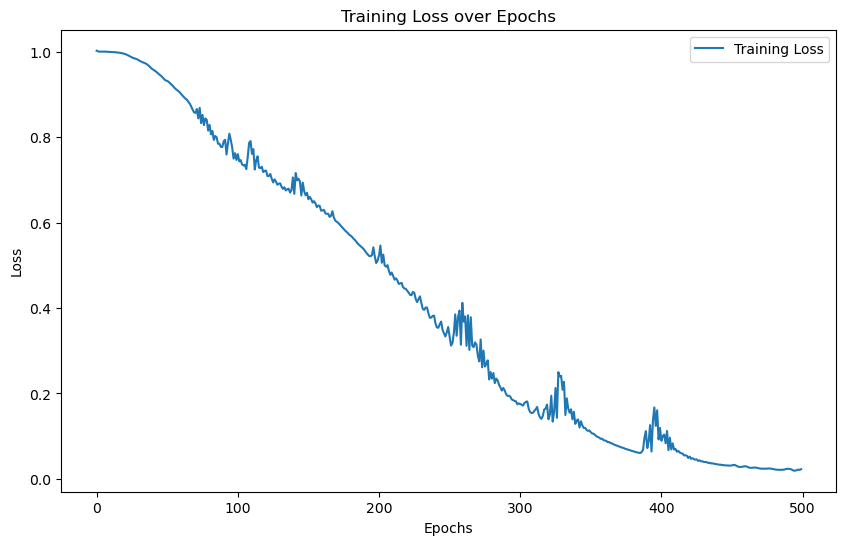

Test Loss: 1.470192790031433


In [17]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 500
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(X_train).reshape(-1, )
    loss = loss_fn(out, y_train)
    train_losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Final evaluation on test data
model.eval()
y_pred = model(X_test).reshape(-1, )
test_loss = loss_fn(y_pred, y_test)
print(f"Test Loss: {test_loss.item()}")

In [18]:
data = np.array(data)
data = scaler.fit_transform(data)

In [19]:
X_data, y_data = data[:, :-1], data[:, -1]

In [20]:
X_data = torch.from_numpy(X_data).type(torch.Tensor)
y_data = torch.from_numpy(y_data).type(torch.Tensor).view(-1)

# X_data = X_data.view([X_data.shape[0], X_data.shape[1], 1])


In [21]:
model.eval()
with torch.no_grad():
    y_data_pred = model(X_data).reshape(-1, )
# y_data_pred = model(X_data).reshape(-1, )


y_data_np = y_data.cpu().numpy()
# y_data_pred = y_data_pred.detach().cpu().numpy()


plt.figure(figsize=(14, 4))
plt.plot(y_data_np, label='Serie Completa Original', color='blue')
plt.plot(y_data_pred, label='Serie Completa Predicha', color='red', alpha=0.7)
plt.axvline(x=len(train), color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación entre la Serie Completa Original y la Serie Completa Predicha')
plt.legend()
plt.show()

RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [ ]:
stop

NameError: name 'stop' is not defined

## Using Validation data during training

In [ ]:
window = 12
data =  series_to_supervised(df['0'], window)

In [ ]:
data

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
12,-0.014493,-0.068702,-0.068702,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,0.067227
13,-0.068702,-0.068702,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,0.067227,0.104820
14,-0.068702,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,0.067227,0.104820,0.090439
15,-0.428570,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,0.067227,0.104820,0.090439,0.162920
16,-0.015748,0.055556,0.068966,0.050847,-0.023438,0.056410,0.270140,-0.318330,0.067227,0.104820,0.090439,0.162920,0.009524
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.152000,-0.034483,0.104900,0.017857,0.073892,0.071225,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080
214,-0.034483,0.104900,0.017857,0.073892,0.071225,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080,0.043796
215,0.104900,0.017857,0.073892,0.071225,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080,0.043796,0.077307
216,0.017857,0.073892,0.071225,-0.118280,0.045822,0.105770,0.057895,-0.012987,0.085427,0.133080,0.043796,0.077307,0.043732


In [ ]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()

train, test = train_test_split(data, test_size=0.1, shuffle=False)
train, val = train_test_split(train, test_size=(2/9), shuffle=False)

train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

In [ ]:
print("Data size:", len(data), f"({len(data) / len(data) * 100:.3f}%)")
print("Training set size:", len(train), f"({len(train) / len(data) * 100:.3f}%)")
print("Validation set size:", len(val), f"({len(val) / len(data) * 100:.3f}%)")
print("Test set size:", len(test), f"({len(test) / len(data) * 100:.3f}%)")


Data size: 206 (100.000%)
Training set size: 143 (69.417%)
Validation set size: 42 (20.388%)
Test set size: 21 (10.194%)


In [ ]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_val, y_val = val[:, :-1], val[:, -1]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(143, 12) (143,)
(21, 12) (21,)
(42, 12) (42,)


In [ ]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
X_val = torch.from_numpy(X_val).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y_test).type(torch.Tensor).view(-1)
y_val = torch.from_numpy(y_val).type(torch.Tensor).view(-1)

In [ ]:
X_train = X_train.view([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.view([X_test.shape[0], X_test.shape[1], 1])
X_val = X_val.view([X_val.shape[0], X_val.shape[1], 1])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([143, 12, 1]), torch.Size([42, 12, 1]), torch.Size([21, 12, 1]))

In [ ]:
class HybridLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(HybridLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out


model = HybridLSTM(input_dim=1, hidden_dim=32, output_dim=1, num_layers=1)  
model

FeedForwardNN(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (activation): ReLU()
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
train_losses = []
val_losses = []

for epoch in range(epochs):
    '''Training phase'''
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(X_train).reshape(-1, )
    loss = loss_fn(out, y_train)
    train_losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    '''Validation phase'''
    model.eval()
    with torch.no_grad():
        val_out = model(X_val).reshape(-1, )
        val_loss = loss_fn(val_out, y_val)
        val_losses.append(val_loss.item())


    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Final evaluation on test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test).reshape(-1, )
    test_loss = loss_fn(y_pred, y_test)
print(f"Test Loss: {test_loss.item()}")

c:\Users\ramir\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([143])) that is different to the input size (torch.Size([1716])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1716) must match the size of tensor b (143) at non-singleton dimension 0

In [ ]:
data = np.array(data)
data = scaler.fit_transform(data)
X_data, y_data = data[:, :-1], data[:, -1]

In [ ]:
X_data = torch.from_numpy(X_data).type(torch.Tensor)
y_data = torch.from_numpy(y_data).type(torch.Tensor).view(-1)

X_data = X_data.view([X_data.shape[0], X_data.shape[1], 1])

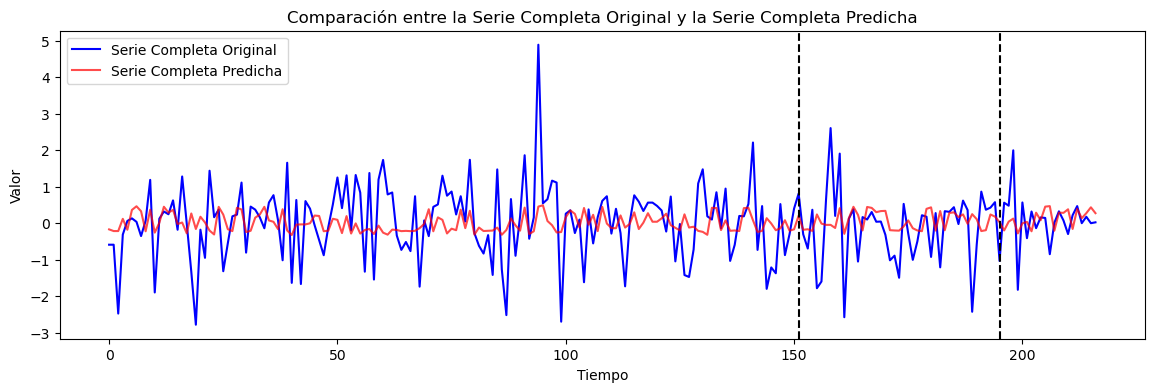

In [ ]:
model.eval()
with torch.no_grad():
    y_data_pred = model(X_data).reshape(-1, )

y_data_np = y_data.cpu().numpy()
y_data_pred_np = y_data_pred.cpu().numpy()


plt.figure(figsize=(14, 4))
plt.plot(y_data_np, label='Serie Completa Original', color='blue')
plt.plot(y_data_pred_np, label='Serie Completa Predicha', color='red', alpha=0.7)
plt.axvline(x=len(train), color='k', linestyle='--', linewidth=1.5)
plt.axvline(x=len(train)+len(val), color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación entre la Serie Completa Original y la Serie Completa Predicha')
plt.legend()
plt.show()